# setup

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from tempfile import mkdtemp
import pandas as pd

from sklearn.pipeline import Pipeline

from src.io import CsvDataLoader
from src.preproc import RawDataCleaner

pd.set_option('display.max_rows', 100)

# load raw data

In [3]:
pipe = Pipeline([
    ('load_data', CsvDataLoader(file_name='polish_sentiment_dataset.csv')),
    ('basic_cleaning', RawDataCleaner()),
], memory=mkdtemp())

In [4]:
data = pipe.fit_transform(None)

# basic eda

In [5]:
data.shape

(917641, 3)

In [6]:
data['negative'].value_counts(dropna=False)/len(data)

0.0    0.80015
1.0    0.19985
Name: negative, dtype: float64

<AxesSubplot:ylabel='Frequency'>

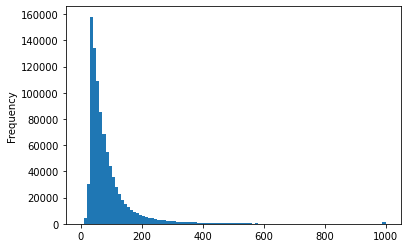

In [7]:
data['len'].clip(upper=1000).plot.hist(bins=100)